# Düsseldorf apartment evaluation based on neighborhood clustering
## Importing relevant libraries

In [1056]:
# Standard libraries
import pandas as pd
import numpy as np

# Libraries for data scraping
from requests import get
from bs4 import BeautifulSoup

#Libraries for geolocation and mapping
import geojson
import requests
import folium
import geopandas as gpd

## import k-means from clustering stage
from sklearn.cluster import KMeans

## Mapping Düsseldorf
First, to get a feeling of the general structure of the city, it makes sense to map the city and add information on its administrative structure and some transportation infrastructure. 

In this step, I will to the following:
* Extract the attribution of each neighbourhood to a district
* Identify the geolocation center of each neighbourhood (for clustering with Foursquare data)
* Extract the shape of each neighbourhood from a geojsonfile for mapping
* Map the city with its districts and colour-coded neighborhoods
* Add information on public transport in Düsseldorf
    * Bus and tram stops
    * City train stops
    * Local train and long distance train stations

_Note: Data on the districts and neighborhoods attribution and shape kindly provided by the Open-Data Team of the city of Düsseldorf. Data on transportation is kindly provided by the 'Verkehrsverbund Rhein-Ruhr', the local public service provider. Geolocation centers of the neighborhoods are scraped using the bing maps API._

In [1057]:
# Reading the attribution of boroughs to districts
bordis = pd.read_csv('https://opendata.duesseldorf.de/sites/default/files/Stadtteile%20D%C3%BCsseldorf%202017.csv',sep = ';')
#Removing irrelevant data from the table
bordis.drop(columns = ['Stadtteilnummer'],inplace=True)
# Making the column names english/python-friendly
bordis.rename(columns={'Stadtteil':'borough','Stadtbezirksnummer':'district'}, inplace=True)
#Checking the imported data
bordis.head()

borough  district
0   Altstadt         1
1  Angermund         5
2    Benrath         9
3       Bilk         3
4  Carlstadt         1

Note that the districts have no names, but are officially referred to only by a number.

Now, the geolocation center of the boroughs will be determined and added to the dataframe. This will be lated later for the neighbourhood clustering.

In [1058]:
import geocoder

In [1059]:
bing_API = 'AsEMIuNbuY3uQQX_8JHSjJ-fcqFL0sVDfu1sUNfoKydv_aKtvVu61JhGI2f6O3WT'


In [1060]:
df_coords = pd.DataFrame({'borough': [], 'latitude' : [], 'longitude' : []})
for bor in bordis['borough']:
    g = geocoder.bing(bor+', Düsseldorf, Germany',key=bing_API)
    c = pd.DataFrame({'borough': [bor], 'latitude' : [g.lat], 'longitude' : [g.lng]})
    df_coords = df_coords.append(c)
borough_loc = pd.merge(bordis,df_coords,on='borough')
borough_loc.head()

borough  district   latitude  longitude
0   Altstadt         1  51.227871    6.77573
1  Angermund         5  51.331371    6.78522
2    Benrath         9  51.162231    6.87296
3       Bilk         3  51.207130    6.77711
4  Carlstadt         1  51.223080    6.77338

Next, we need the shape of the boroughs from a geojson file.

In [1061]:
#Read geojson file with district borders
dd_boroughs = gpd.read_file('https://opendata.duesseldorf.de/sites/default/files/Stadtteile_ETRS89_4647.geojson')
#Remove irrelevant information and make english/python-friendly
dd_boroughs.drop(columns = ['Quelle','Stand','Stadtteil'],inplace=True)
dd_boroughs.rename(columns={'Name':'borough','Stadtbezirk':'district'}, inplace=True)
#Check imported data
dd_boroughs.head()

district     borough                                           geometry
0         5    Wittlaer  POLYGON ((32344324.834 5687063.605, 32344321.2...
1         5   Angermund  POLYGON ((32347439.099 5690237.369, 32347436.1...
2         4      Lörick  POLYGON ((32342711.938 5680265.288, 32342706.3...
3         4      Heerdt  POLYGON ((32341930.043 5678691.389, 32341903.5...
4         4  Oberkassel  POLYGON ((32344219.584 5677984.643, 32344219.5...

In [1062]:
dd = folium.Map([51.22172, 6.797], zoom_start=12)
folium.Choropleth(
    geo_data=dd_boroughs,
    data=bordis,
    columns=['borough', 'district'],
    key_on='feature.properties.borough',
    fill_color='Paired', 
    bins=10,
    legend_name='District',
    reset=True,
    fill_opacity=0.7,
    line_weight=1,
).add_to(dd)
dd

### Adding public transportation data
Finally, lets add the information on tram/bus stops, city train stations and local/long distance train stations.
The data for the bus/tram stops was downloaded from https://www.openvrr.de/dataset/haltestellen. It contains all bus and tram stops in the entire provider area, so after reading the file, it will be filtered to only stops in Düsseldorf.

In [1063]:
# add data for tram stations
tram_df = pd.read_csv('../data-for-capstone-test/haltestellenliste.csv',sep=';',encoding='latin-1')
# remove unnecessary columns
tram_df.drop(columns=['Tarifzone','Unnamed: 8','Unnamed: 9','Globale ID','AGS (Teilortnummer)'],inplace=True)
#simplifying the remaining column names, making them more accesible to python and english native speakers
tram_df.rename(columns={'Ort':'city','Name ohne Ort':'name_wo_city','Name mit Ort':'name_w_city',\
                        'X-Koordinate (MRCV)':'lng','Y-Koordinate (MRCV)':'lat'}, inplace=True)
#remove stations that are not in Düsseldorf (note the tailing white spaces!)
tram_df.drop(tram_df[tram_df.city != 'Düsseldorf          '].index,inplace=True)
# turn MRCV-bogus coordinates into real coordinates
lng = tram_df['lng'].str.rsplit(".", 1).str[0]+tram_df['lng'].str.rsplit(".", 1).str[1]
lat = tram_df['lat'].str.rsplit(".", 1).str[0]+tram_df['lat'].str.rsplit(".", 1).str[1]
tram_df['lng']= lng
tram_df['lat'] = lat
tram_df['lat'] = tram_df['lat'].astype(float)
tram_df['lng'] = tram_df['lng'].astype(float)
# Re-set the indices from the original data frame to 0 through n
tram_df.reset_index(drop=True,inplace=True)
# Drop stations with NULL value coordinates
tram_df = tram_df.dropna(subset=['lat','lng'],how='all')
#show first five entries of dataframe to check
tram_df.head()

city                                       name_wo_city  \
0  Düsseldorf            Corellistraße                                 ...   
1  Düsseldorf            Adolf-Klarenbach-Straße                       ...   
2  Düsseldorf            Benrath Btf                                   ...   
3  Düsseldorf            Benrath S                                     ...   
4  Düsseldorf            Urdenbacher Allee                             ...   

        lng        lat                                        name_w_city  
0  6.880439  51.154249  D-Corellistraße                               ...  
1  6.835829  51.173120  D-Adolf-Klarenbach-Straße                     ...  
2  6.884077  51.161100  D-Benrath Btf                                 ...  
3  6.878194  51.161945  D-Benrath S                                   ...  
4  6.874888  51.162085  D-Urdenbacher Allee                           ...

In [1064]:
# Geolocations of long distance train stations
stations_df = pd.read_csv('https://opendata.duesseldorf.de/sites/default/files/Standorte%20der%20Fernbahnh%C3%B6fe%20in%20D%C3%BCsseldorf_1.csv', sep=';')
stations_df.head()

LATITUDE  LONGITUDE                          NAME                    STR  \
0  51.219773   6.794194                  Hauptbahnhof  Konrad-Adenauer-Platz   
1  51.291538   6.786854  Bahnhof Düsseldorf Flughafen            Ahrensplatz   
2  51.163071   6.878417                       Benrath           Heubesstraße   

   HsNr    PLZ         ORT      STADTTEIL  PLANQUADRAT  UTM EAST  UTM NORTH  
0    14  40210  Düsseldorf     Stadtmitte         4576  32345960    5676577  
1     1  40472  Düsseldorf  Lichtenbroich         4584  32345688    5684572  
2    23  40597  Düsseldorf        Benrath         5170  32351659    5670099

In [1065]:
# Geolocations of tram stations
citytrain_df = pd.read_csv('https://opendata.duesseldorf.de/sites/default/files/Standorte%20der%20S-Bahnh%C3%B6fe%20in%20D%C3%BCsseldorf.csv', sep=';')
citytrain_df.head()

LATITUDE  LONGITUDE          NAME                    STR   HsNr    PLZ  \
0  51.201970   6.838235   Eller-Mitte          Gumbertstraße   63.0  40229   
1  51.219773   6.794194  Hauptbahnhof  Konrad-Adenauer-Platz   14.0  40210   
2  51.229167   6.797755      Wehrhahn            Am Wehrhahn  101.0  40211   
3  51.236944   6.796696           Zoo         Schinkelstraße   51.0  40211   
4  51.248033   6.793830     Derendorf          Münsterstraße  199.0  40470   

          ORT   STADTTEIL  PLANQUADRAT  UTM EAST  UTM NORTH  
0  Düsseldorf       Eller         4874  32348977    5674506  
1  Düsseldorf  Stadtmitte         4576  32345960    5676577  
2  Düsseldorf  Stadtmitte         4677  32346240    5677614  
3  Düsseldorf  Pempelfort         4678  32346192    5678481  
4  Düsseldorf   Düsseltal         4679  32346029    5679720

In [1066]:
# Instantiate a feature group for the tram stations
tram_locations = folium.map.FeatureGroup()
citytrain_locations = folium.map.FeatureGroup()
train_locations = folium.map.FeatureGroup()

# loop through the tram stations and add each one to the feature group
for lat,lng in zip(tram_df.lat,tram_df.lng):
    tram_locations.add_child(
        folium.Circle(
            [lat,lng], radius = 5, color='white',fill=False
        )
    )
for lat, lng in zip(citytrain_df.LATITUDE,citytrain_df.LONGITUDE):
    citytrain_locations.add_child(
        folium.CircleMarker(
            [lat,lng], radius = 4, color='blue',fill=True, fill_color='blue',fill_opacity=0.6
        )
    )
for lat,lng in zip(stations_df.LATITUDE,stations_df.LONGITUDE):
    train_locations.add_child(
        folium.CircleMarker(
            [lat,lng], radius = 4, color='red',fill=True, fill_color='red',fill_opacity=0.6
        )
    )

In [1067]:
# add stops to map
dd.add_child(tram_locations)
dd.add_child(citytrain_locations)
dd.add_child(train_locations)

## Looking up apartment information
A popular provider for information on rental apartments in Germany is 'Immbolienscout 24'. The data for available apartments is scraped and apartments not suitabel for further analysis are removed. This includes apartments without a street address, which makes them impossible to pinpoint on a map.

In [1068]:
# Initiate variable for data scrapint
all_appts = [] # the dataframe-list with all dataframes containing data
container = [] # the dataframe from each individual page
i=1
l=1
while l != 0:
    url = 'https://www.immobilienscout24.de/Suche/de/nordrhein-westfalen/duesseldorf/wohnung-mieten?pagenumber='+str(i)
    response = get(url)
    html_soup = BeautifulSoup(response.text,'html.parser')
    container = html_soup('div', class_='result-list-entry__data')
    all_appts.append(container)
    l=len(container)
    i=i+1

if (len(all_appts)==0):
    print('There was an error and no data was collected.')
else:
    print('Data was scraped succesfully.')

Data was scraped succesfully.


The data for each individual apartment must be identified within the resulting list of dataframes.

In [1069]:
# Create empty lists for apartment data
addresss = []
prices = []
sizes = []
roomss = []
appt_container = all_appts[1]

In [1070]:
#Cycling through all pages (each containing up to 20 aparments)
for j in range(len(all_appts)):
    #Cycling through all apartments in that list
    for i in range(len(appt_container)):
        appt = appt_container[i]
        if appt.find_all('dt',string='Preis') == []: #identifies rental apartments as opposed to apartments on sale
            address =  appt.find('button', title='Auf der Karte anzeigen').text
            addresss.append(address)

            price = appt.find_all('dd',class_='font-nowrap font-highlight font-tabular')[0].text
            prices.append(price)

            size = appt.find_all('dd',class_='font-nowrap font-highlight font-tabular')[1].text
            sizes.append(size)

            rooms = appt.find('span',class_='onlySmall').text
            roomss.append(rooms)
            i=i+1
        j=j+1

In [1071]:
data_df = pd.DataFrame({'address': addresss, 'price':prices,'size':sizes,'rooms':roomss})
data_df.head()

address       price       size  \
0   Hohenzollernallee  16, Flingern Nord, Düsseldorf  1.435,17 €  106,36 m²   
1   Hohenzollernallee  16, Flingern Nord, Düsseldorf  1.076,63 €   74,92 m²   
2   Hohenzollernallee  12, Flingern Nord, Düsseldorf  1.306,42 €   96,06 m²   
3  Hohenzollernallee  10d, Flingern Nord, Düsseldorf  1.802,87 €  146,09 m²   
4   Hohenzollernallee  10, Flingern Nord, Düsseldorf  1.588,17 €   115,8 m²   

   rooms  
0  3 Zi.  
1  2 Zi.  
2  3 Zi.  
3  4 Zi.  
4  4 Zi.

In [1072]:
print('{} apartments were identified.'.format(len(data_df)))

1460 apartments were identified.


### Cleaning the data

In [1073]:
#Copy the data into a new dataframe
apt_data = data_df.copy()

In [1074]:
# Remove units to leave numbers (as strings)
apt_data['price'] = apt_data['price'].str.split(" ", 1).str[0]
apt_data['size'] = apt_data['size'].str.split(" ", 1).str[0]
apt_data['rooms'] = apt_data['rooms'].str.split(' ',1).str[0]

## Turn price into float
As a result of German number encoding, turning the prices from strings to floats requires some elaborate back-and forth. If any reviewer knows an easier way to this, please do let me know.

In [1075]:
#Split strings at thousands-point and turn thousands and rest into separate columns
apt_data['price-t'] = apt_data['price'].str.split(".", 1).str[-2]
apt_data['price-h'] = apt_data['price'].str.split(".", 1).str[-1]
#Columns were the rent was below 1000 Euro reture a NaN value for price-t, which will be replace by 0
apt_data['price-t'] = apt_data['price-t'].fillna(0)
#replace decimal comma for point (while we are at it, this will be done for 'size' and 'rooms' as well)
apt_data['price-h'] = [x.replace(',','.') for x in apt_data['price-h']]
apt_data['size'] = [x.replace(',','.') for x in apt_data['size']]
apt_data['rooms'] = [x.replace(',','.') for x in apt_data['rooms']]

In [1076]:
# Change data type from strings to numeric for numerical values
apt_data['size'] = apt_data['size'].apply(pd.to_numeric)
apt_data['rooms'] = apt_data['rooms'].apply(pd.to_numeric)
apt_data['price-t'] = apt_data['price-t'].apply(pd.to_numeric)*1000
apt_data['price-h'] = apt_data['price-h'].apply(pd.to_numeric)
apt_data['price'] = apt_data['price-t']+apt_data['price-h']

#drop columns not anymore required
apt_data.drop(columns = ['price-t','price-h'],inplace=True)

In [1077]:
apt_data.head()

address    price    size  rooms
0   Hohenzollernallee  16, Flingern Nord, Düsseldorf  1435.17  106.36    3.0
1   Hohenzollernallee  16, Flingern Nord, Düsseldorf  1076.63   74.92    2.0
2   Hohenzollernallee  12, Flingern Nord, Düsseldorf  1306.42   96.06    3.0
3  Hohenzollernallee  10d, Flingern Nord, Düsseldorf  1802.87  146.09    4.0
4   Hohenzollernallee  10, Flingern Nord, Düsseldorf  1588.17  115.80    4.0

This looks about right.

## Remove incomplete data sets
Now, we prepare the data for geolocation. 
To do this, first, we have to remove apartments without a complete address, because they will be impossible to pin-point on our map.

In [1078]:
# Prepare address data for geolocation by splitting the single columen into street, borough and city information
# In cases where not street address is given, this results in borough = city and street = borough, 
# which is unsuitable for geolocation
city = apt_data['address'].str.rsplit(",", 1).str[-1]
borough = apt_data['address'].str.rsplit(",", 2).str[1]
street = apt_data['address'].str.rsplit(",", 2).str[0]
# add data to data_frame
apt_data['city']= city
apt_data['borough'] = borough
apt_data['street'] = street
# Drop data unsuitable for geolocation, i.e. all that did not have a street address
apt_data.drop(apt_data[apt_data.borough == ' Düsseldorf'].index, inplace=True)
# remove address column
apt_data.drop(columns = ['address'],inplace=True)
# For control purposes
apt_data.head()

price    size  rooms         city         borough                  street
0  1435.17  106.36    3.0   Düsseldorf   Flingern Nord   Hohenzollernallee  16
1  1076.63   74.92    2.0   Düsseldorf   Flingern Nord   Hohenzollernallee  16
2  1306.42   96.06    3.0   Düsseldorf   Flingern Nord   Hohenzollernallee  12
3  1802.87  146.09    4.0   Düsseldorf   Flingern Nord  Hohenzollernallee  10d
4  1588.17  115.80    4.0   Düsseldorf   Flingern Nord   Hohenzollernallee  10

In [1079]:
print('{} apartments were identfied. They are located in {} boroughs.'\
      .format(len(apt_data),len(apt_data['borough'].unique())))

1314 apartments were identfied. They are located in 8 boroughs.


In an actual project it would now make sense to reduce the number of apartments based on informal criteria and then locate the apartments for further analysis. As I will demonstrate below, this approach does result in a reasonably low number of apartments, which could be located for borough clustering. However, the remaining apartments are located in a very limited number of boroughs (less than 3 out of an initial 54 possible boroughs).

For this assignment the limited number of boroughs does not make much sense. Therefore, instead of actually applying our informal criteria, we will randomly select a sample of 200 apartments from the data set located in the 7 boroughs in an alternative approach.

In [1080]:
#Store a copy of dataframe for real approach
apt_real = apt_data.copy()
#Save copy of dataframe for later sampling.
apt_random = apt_data.copy()

## Real life approach

That are still quite many and will likely max out our number of bing map API requests. 
Therefore, now, it is time to reduce the number of apartments by non-formal criteria. This may be the minimum size or number of rooms. Let us first have a look at some descriptive statistics of the available apartments.

In [1081]:
apt_real.describe()

price         size        rooms
count  1314.000000  1314.000000  1314.000000
mean   1345.598333    98.816111     2.722222
std     563.489658    30.426843     0.711729
min     610.000000    61.000000     2.000000
25%    1011.710000    72.000000     2.000000
50%    1243.230000    95.480000     2.750000
75%    1588.170000   115.800000     3.000000
max    2950.000000   176.000000     4.000000

From the price distribution, we can already tell that there are many apartments that exceed our price limit substantially. For now, we will exclude any apartment that costs more than 1100 Euros, which are roughly 75% of the apartments.

In [1082]:
apt_real.drop(apt_real[apt_real.price > 1100].index,inplace=True)
print('{} apartments in {} boroughs remain in the dataset.'.format(len(apt_real),len(apt_real['borough'].unique())))

511 apartments in 4 boroughs remain in the dataset.


That is still quite a lot. There is also quite a number of very large apartments, so let's exlude apartments largern than 75 m^2 as well.

In [1083]:
apt_real.drop(apt_real[apt_real['size'] > 70].index,inplace=True)
print('{} apartments in {} boroughs remain in the dataset.'.format(len(apt_real),len(apt_real['borough'].unique())))

219 apartments in 2 boroughs remain in the dataset.


## Alternative approach using random sample

In [1087]:
apt_sample = apt_random.sample(n=300,replace=True)
apt_sample.describe()

price        size       rooms
count   300.000000  300.000000  300.000000
mean   1343.461333  100.536433    2.713333
std     577.985657   32.123813    0.676521
min     610.000000   61.000000    2.000000
25%     950.000000   72.000000    2.000000
50%    1291.460000   96.000000    3.000000
75%    1588.170000  115.800000    3.000000
max    2950.000000  176.000000    4.000000

In [1088]:
print('{} apartments in {} boroughs remain in the dataset.'.format(len(apt_sample),len(apt_sample['borough'].unique())))

300 apartments in 8 boroughs remain in the dataset.


In [1089]:
#Reset index to series from 0 to 199
apt_sample.reset_index(drop=True,inplace=True)
apt_sample.head()

price   size  rooms         city         borough  \
0  1291.46  94.96    3.0   Düsseldorf   Flingern Nord   
1   613.00  67.88    2.0   Düsseldorf       Hellerhof   
2  1291.46  94.96    3.0   Düsseldorf   Flingern Nord   
3  1195.00  74.50    2.5   Düsseldorf            Bilk   
4  1306.42  96.06    3.0   Düsseldorf   Flingern Nord   

                      street  
0       Hohenzollernallee  2  
1  Carlo-Schmid-Straße 19-29  
2       Hohenzollernallee  2  
3          Aachener Str. 113  
4      Hohenzollernallee  12

## Looking up and importing geolocation of relevant apartments

In [1090]:
apt_coords = pd.DataFrame({'street': [], 'latitude' : [], 'longitude' : []})

for apt in apt_sample['street']:
    g = geocoder.bing(apt+'Düsseldorf, Germany',key=bing_API)
    c = pd.DataFrame({'street': [apt], 'latitude' : [g.lat], 'longitude' : [g.lng]})
    apt_coords = apt_coords.append(c)
    
    

In [1092]:
apt_coords.head()

street  latitude  longitude
0       Hohenzollernallee  2  51.23348    6.82384
0  Carlo-Schmid-Straße 19-29  51.13073    6.90785
0       Hohenzollernallee  2  51.23348    6.82384
0          Aachener Str. 113  51.20152    6.77069
0      Hohenzollernallee  12  51.23383    6.82499

Let us now add these apartments to the map.

In [1093]:
#Instantia feature group
apt_locations = folium.map.FeatureGroup()

# loop through the tram stations and add each one to the feature group
for lat,lng in zip(apt_coords.latitude,apt_coords.longitude):
    apt_locations.add_child(
        folium.Circle(
            [lat,lng], radius = 100, color='yellow',fill=True
        )
    )

In [1094]:
# add apartments to map
dd.add_child(apt_locations)

Ignoring the one apartment in district 10 (to the south, zoom out or move map to see), the apartments are located in districts 1, 2, 3, 4, and 6, which are all adjacent. For the subsequent clustering let us include all of the neighborhoods of these districts.

In [1095]:
# remove districts 5,7,8,9,10, which do not interest us
for n in 5,7,8,9,10:
    borough_loc.drop(borough_loc[borough_loc['district'] == n].index, inplace=True)
print('{} boroughs in {} districts will be analysed.'.format(len(borough_loc),len(borough_loc['district'].unique())))

25 boroughs in 5 districts will be analysed.


## Analysing and clustering the boroughs using Foursquare Data

In [1097]:
#Input Foursquare credentials!
CLIENT_ID = 'VP5K2R0IUFG0PNIMBLUUWCTYLIN0VI12LYNPFIE05JSVQFTB' # your Foursquare ID
CLIENT_SECRET = 'R3MJF1YNU32BE1IMON1H0DCWI3K0QKKYLHXV0WV3ZVLS21GP' # your Foursquare Secret
VERSION = '20200525' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VP5K2R0IUFG0PNIMBLUUWCTYLIN0VI12LYNPFIE05JSVQFTB
CLIENT_SECRET:R3MJF1YNU32BE1IMON1H0DCWI3K0QKKYLHXV0WV3ZVLS21GP


The following code defines a function that looks up venues in a defined radius around a coordinate. Since the neighborhoods are quite small, the radius as set to 500 m.

_Note: This bit of code was copy-pasted from the labs in the course._

In [1098]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name,lat,lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1099]:
#Calling the function
dd_venues = getNearbyVenues(names=borough_loc['borough'],latitudes=borough_loc['latitude'],longitudes=borough_loc['longitude'])

Altstadt
Bilk
Carlstadt
Derendorf
Düsseltal
Flehe
Flingern Nord
Flingern Süd
Friedrichstadt
Golzheim
Hafen
Hamm
Heerdt
Lichtenbroich
Lörick
Mörsenbroich
Niederkassel
Oberbilk
Oberkassel
Pempelfort
Rath
Stadtmitte
Unterbilk
Unterrath
Volmerswerth


In [1100]:
print('{} venues were found in the analysed {} boroughs.'.format(len(dd_venues),len(borough_loc)))
print('There are {} unique categories.'.format(len(dd_venues['Venue Category'].unique())))

808 venues were found in the analysed 25 boroughs.
There are 154 unique categories.


In [1101]:
# one hot encoding
dd_onehot = pd.get_dummies(dd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dd_onehot['Neighborhood'] = dd_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dd_onehot.columns[-1]] + list(dd_onehot.columns[:-1])
dd_onehot = dd_onehot[fixed_columns]
dd_grouped = dd_onehot.groupby('Neighborhood').mean().reset_index()

In [1102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [1103]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [1104]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dd_grouped['Neighborhood']

for ind in np.arange(dd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0     Altstadt        Clothing Store                  Café   
1         Bilk                  Café    Italian Restaurant   
2    Carlstadt              Boutique           Coffee Shop   
3    Derendorf                 Hotel  Fast Food Restaurant   
4    Düsseltal                Bakery             Drugstore   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop                 Plaza                   Bar   
1                   Pub                   Bar   Indie Movie Theater   
2                  Café    Italian Restaurant               Brewery   
3                Bakery     Trattoria/Osteria            Restaurant   
4                  Park        Ice Cream Shop        Breakfast Spot   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                 Hotel               Brewery              Boutique   
1           Coffee Shop            Restaurant          Camera Store   
2            Steakhouse                 Hotel                Bakery   
3      Asian Restaurant                  Park                Bistro   
4              Pharmacy           Supermarket      Greek Restaurant   

  9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
0     German Restaurant  ...          Shopping Mall     Italian Restaurant   
1                  Pool  ...              Pet Store             Smoke Shop   
2                 Plaza  ...         Ice Cream Shop   Fast Food Restaurant   
3  Colombian Restaurant  ...           Cocktail Bar         Clothing Store   
4               Brewery  ...                  Plaza           Cupcake Shop   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0              Bookstore     Mexican Restaurant              Nightclub   
1                   Park       Doner Restaurant     Mexican Restaurant   
2         Clothing Store            Pizza Place           Cocktail Bar   
3           Burger Joint             Soup Place                    Pub   
4     Dim Sum Restaurant           Dessert Shop          Deli / Bodega   

  16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0            Pizza Place      Electronics Store              Gift Shop   
1   Fast Food Restaurant              Gastropub       Greek Restaurant   
2             Restaurant      French Restaurant       Pedestrian Plaza   
3  Portuguese Restaurant                   Café     Dim Sum Restaurant   
4            Flower Shop               Dive Bar       Doner Restaurant   

  19th Most Common Venue  20th Most Common Venue  
0              BBQ Joint    Fast Food Restaurant  
1         Ice Cream Shop            Burger Joint  
2                    Bar  Furniture / Home Store  
3      Polish Restaurant      Italian Restaurant  
4      Electronics Store             Event Space  

[5 rows x 21 columns]

### Clustering the boroughs

In [1105]:
# set number of clusters
kclusters = 11

dd_grouped_clustering = dd_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:25] 

array([ 0,  0,  0,  3,  3,  5,  3,  3,  3,  0,  1,  8,  0,  6,  4,  9, 10,
        3,  0,  3, 10,  0,  0,  2,  7], dtype=int32)

In [1106]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [1107]:
dd_merged = borough_loc.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='borough')
dd_merged.reset_index(drop=True,inplace=True)
dd_merged.head()

borough  district   latitude  longitude  Cluster Labels  \
0   Altstadt         1  51.227871    6.77573               0   
1       Bilk         3  51.207130    6.77711               0   
2  Carlstadt         1  51.223080    6.77338               0   
3  Derendorf         1  51.248199    6.78311               3   
4  Düsseltal         2  51.237450    6.80555               3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Clothing Store                  Café           Coffee Shop   
1                  Café    Italian Restaurant                   Pub   
2              Boutique           Coffee Shop                  Café   
3                 Hotel  Fast Food Restaurant                Bakery   
4                Bakery             Drugstore                  Park   

  4th Most Common Venue 5th Most Common Venue  ... 11th Most Common Venue  \
0                 Plaza                   Bar  ...          Shopping Mall   
1                   Bar   Indie Movie Theater  ...              Pet Store   
2    Italian Restaurant               Brewery  ...         Ice Cream Shop   
3     Trattoria/Osteria            Restaurant  ...           Cocktail Bar   
4        Ice Cream Shop        Breakfast Spot  ...                  Plaza   

  12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0     Italian Restaurant              Bookstore     Mexican Restaurant   
1             Smoke Shop                   Park       Doner Restaurant   
2   Fast Food Restaurant         Clothing Store            Pizza Place   
3         Clothing Store           Burger Joint             Soup Place   
4           Cupcake Shop     Dim Sum Restaurant           Dessert Shop   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0              Nightclub            Pizza Place      Electronics Store   
1     Mexican Restaurant   Fast Food Restaurant              Gastropub   
2           Cocktail Bar             Restaurant      French Restaurant   
3                    Pub  Portuguese Restaurant                   Café   
4          Deli / Bodega            Flower Shop               Dive Bar   

  18th Most Common Venue 19th Most Common Venue  20th Most Common Venue  
0              Gift Shop              BBQ Joint    Fast Food Restaurant  
1       Greek Restaurant         Ice Cream Shop            Burger Joint  
2       Pedestrian Plaza                    Bar  Furniture / Home Store  
3     Dim Sum Restaurant      Polish Restaurant      Italian Restaurant  
4       Doner Restaurant      Electronics Store             Event Space  

[5 rows x 25 columns]

### Draw map with borough clusters, apartments and transport data

In [1108]:
dd_cluster_map = folium.Map([51.22172, 6.767], zoom_start=12.5)


In [1109]:
analysed_boroughs = dd_boroughs.copy()
for n in 5,7,8,9,10:
    analysed_boroughs.drop(dd_boroughs[dd_boroughs['district'] == n].index, inplace=True)
folium.Choropleth(
    geo_data=analysed_boroughs,
    data=dd_merged,
    columns=['borough','Cluster Labels'],
    key_on='feature.properties.borough',
    fill_color='Paired',
    legend_name='Cluster',
    bins=kclusters+1,
    reset=True,
    fill_opacity=0.7,
    line_weight=1,
).add_to(dd_cluster_map)

In [1110]:
#Adding locations
dd_cluster_map.add_child(tram_locations)
dd_cluster_map.add_child(citytrain_locations)
dd_cluster_map.add_child(train_locations)
dd_cluster_map.add_child(apt_locations)
#Show map
dd_cluster_map

### Identify cluster characteristics

In [1111]:
dd_merged.loc[dd_merged['Cluster Labels'] == 0, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
0   51.227871        Clothing Store                  Café   
1   51.207130                  Café    Italian Restaurant   
2   51.223080              Boutique           Coffee Shop   
9   51.251740    Italian Restaurant  Fast Food Restaurant   
12  51.233318        Ice Cream Shop                 Plaza   
18  51.231770    Italian Restaurant                   Bar   
21  51.223019           Coffee Shop                  Café   
22  51.211411                  Café    Italian Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Coffee Shop                 Plaza                   Bar   
1                    Pub                   Bar   Indie Movie Theater   
2                   Café    Italian Restaurant               Brewery   
9            Salad Place         Boat or Ferry                  Café   
12         Metro Station    Italian Restaurant   Japanese Restaurant   
18                 Plaza     Trattoria/Osteria             Gastropub   
21                 Hotel   Japanese Restaurant         Shopping Mall   
22           Pizza Place        Ice Cream Shop       Thai Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Hotel               Brewery              Boutique   
1            Coffee Shop            Restaurant          Camera Store   
2             Steakhouse                 Hotel                Bakery   
9            Event Space                Bakery            Club House   
12             BBQ Joint             Gastropub        Discount Store   
18     German Restaurant                  Café           Supermarket   
21    Italian Restaurant              Boutique        Clothing Store   
22         Deli / Bodega                 Plaza             Juice Bar   

   9th Most Common Venue  ... 11th Most Common Venue  \
0      German Restaurant  ...          Shopping Mall   
1                   Pool  ...              Pet Store   
2                  Plaza  ...         Ice Cream Shop   
9       Greek Restaurant  ...             Steakhouse   
12          Optical Shop  ...      Electronics Store   
18           Yoga Studio  ...                Brewery   
21     German Restaurant  ...                 Bakery   
22        Clothing Store  ...         Farmers Market   

        12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0           Italian Restaurant              Bookstore     Mexican Restaurant   
1                   Smoke Shop                   Park       Doner Restaurant   
2         Fast Food Restaurant         Clothing Store            Pizza Place   
9                    Drugstore         Farmers Market     Falafel Restaurant   
12              Farmers Market     Falafel Restaurant            Event Space   
18           French Restaurant            Snack Place     Spanish Restaurant   
21      Furniture / Home Store      Indian Restaurant              Drugstore   
22  Modern European Restaurant     Salon / Barbershop       Kebab Restaurant   

    15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0                Nightclub            Pizza Place      Electronics Store   
1       Mexican Restaurant   Fast Food Restaurant              Gastropub   
2             Cocktail Bar             Restaurant      French Restaurant   
9        Electronics Store            Yoga Studio            Flower Shop   
12                Dive Bar              Drugstore       Doner Restaurant   
18  Gluten-free Restaurant                   Bank       Greek Restaurant   
21       Electronics Store            Pizza Place      Korean Restaurant   
22              Poke Place               Dive Bar    Rental Car Location   

   18th Most Common Venue 19th Most Common Venue  20th Most Common Venue  
0               Gift Shop              BBQ Joint    Fast Food Restaurant  
1        Greek Restaurant         Ice Cream Shop            Burger Joint  
2        Pedestrian P

In [1112]:
dd_merged.loc[dd_merged['Cluster Labels'] == 1, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
10  51.213402  Fast Food Restaurant    Light Rail Station   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
10           Yoga Studio             Drugstore           Flower Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
10        Farmers Market    Falafel Restaurant           Event Space   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
10     Electronics Store  ...      French Restaurant               Dive Bar   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
10         Discount Store     Dim Sum Restaurant           Dessert Shop   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
10          Deli / Bodega           Dance Studio           Cupcake Shop   

   19th Most Common Venue 20th Most Common Venue  
10               Fountain     Frozen Yogurt Shop  

[1 rows x 21 columns]

In [1113]:
dd_merged.loc[dd_merged['Cluster Labels'] == 2, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
23  51.27224                Bakery             Drugstore   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
23           Supermarket           Yoga Studio           Flower Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
23  Fast Food Restaurant        Farmers Market    Falafel Restaurant   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
23           Event Space  ...       Doner Restaurant      French Restaurant   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
23               Dive Bar         Discount Store     Dim Sum Restaurant   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
23           Dessert Shop          Deli / Bodega           Dance Studio   

   19th Most Common Venue 20th Most Common Venue  
23           Cupcake Shop               Fountain  

[1 rows x 21 columns]

In [1114]:
dd_merged.loc[dd_merged['Cluster Labels'] == 3, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
3   51.248199                 Hotel  Fast Food Restaurant   
4   51.237450                Bakery             Drugstore   
6   51.215641                 Hotel                Bakery   
7   51.215641                 Hotel                Bakery   
8   51.213879                 Hotel                  Café   
17  51.217239                 Hotel           Supermarket   
19  51.234150                 Hotel           Pizza Place   

   3rd Most Common Venue    4th Most Common Venue  5th Most Common Venue  \
3                 Bakery        Trattoria/Osteria             Restaurant   
4                   Park           Ice Cream Shop         Breakfast Spot   
6                   Café                      Bar              Drugstore   
7                   Café                      Bar              Drugstore   
8                    Bar                   Bakery  Vietnamese Restaurant   
17                  Park  Comfort Food Restaurant              Drugstore   
19    Italian Restaurant             Tram Station      French Restaurant   

        6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3            Asian Restaurant                  Park                Bistro   
4                    Pharmacy           Supermarket      Greek Restaurant   
6          Italian Restaurant           Supermarket      Sushi Restaurant   
7          Italian Restaurant           Supermarket      Sushi Restaurant   
8   Middle Eastern Restaurant           Pizza Place                   Pub   
17         Chinese Restaurant            Restaurant         Metro Station   
19                     Museum                   Bar     German Restaurant   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
3   Colombian Restaurant  ...           Cocktail Bar         Clothing Store   
4                Brewery  ...                  Plaza           Cupcake Shop   
6                  Plaza  ...                   Park              BBQ Joint   
7                  Plaza  ...                   Park              BBQ Joint   
8            Coffee Shop  ...              Cafeteria              Rock Club   
17             Pet Store  ...                 Lounge      Korean Restaurant   
19                Bakery  ...          Shopping Mall           Cocktail Bar   

   13th Most Common Venue 14th Most Common Venue    15th Most Common Venue  \
3            Burger Joint             Soup Place                       Pub   
4      Dim Sum Restaurant           Dessert Shop             Deli / Bodega   
6              Restaurant  Vietnamese Restaurant        Turkish Restaurant   
7              Restaurant  Vietnamese Restaurant        Turkish Restaurant   
8              Restaurant     Falafel Restaurant            Clothing Store   
17        Bratwurst Joint     Turkish Restaurant      Gym / Fitness Center   
19      Jewish Restaurant              Drugstore  Mediterranean Restaurant   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
3   Portuguese Restaurant                   Café     Dim Sum Restaurant   
4             Flower Shop               Dive Bar       Doner Restaurant   
6      Falafel Restaurant        Organic Grocery       Business Service   
7      Falafel Restaurant        Organic Grocery       Business Service   
8          Breakfast Spot                  Plaza     Mexican Restaurant   
17      German Restaurant            Event Space           Dance Studio   
19     Photography Studio       Doner Restaurant     Chinese Restaurant   

   19th Most Common Venue 20th Most Common Venue  
3       Polish Restaurant     Italian Restaurant  
4       Electronics Store            Event Space  
6               Cafeteria       Greek Restaurant  
7               Cafeteria       Greek Restaurant  
8      Miscellaneous Shop           Cupcake Shop  
17             Hobby Shop         History Museum  
19                   Café             Restaurant  

[7 rows x 21 columns]

In [1115]:
dd_merged.loc[dd_merged['Cluster Labels'] == 4, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
14  51.24572    Italian Restaurant              Bus Stop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
14      Asian Restaurant             Multiplex           Yoga Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
14     Electronics Store           Flower Shop  Fast Food Restaurant   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
14        Farmers Market  ...            Event Space       Doner Restaurant   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
14              Drugstore      French Restaurant               Dive Bar   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
14         Discount Store     Dim Sum Restaurant           Dessert Shop   

   19th Most Common Venue 20th Most Common Venue  
14          Deli / Bodega           Dance Studio  

[1 rows x 21 columns]

In [1116]:
dd_merged.loc[dd_merged['Cluster Labels'] == 5, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
5  51.190651          Soccer Field                 Beach   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5           Sports Club                   Gym              Fountain   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5           Flower Shop  Fast Food Restaurant        Farmers Market   

  9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
5    Falafel Restaurant  ...      Electronics Store            Yoga Studio   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
5      French Restaurant       Doner Restaurant               Dive Bar   

  16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
5         Discount Store     Dim Sum Restaurant           Dessert Shop   

  19th Most Common Venue 20th Most Common Venue  
5          Deli / Bodega           Dance Studio  

[1 rows x 21 columns]

In [1117]:
dd_merged.loc[dd_merged['Cluster Labels'] == 6, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude       1st Most Common Venue 2nd Most Common Venue  \
13  51.283218  Construction & Landscaping     Trattoria/Osteria   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
13              Pharmacy           Pizza Place            Hobby Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
13        Discount Store    Falafel Restaurant           Event Space   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
13     Electronics Store  ...       Doner Restaurant               Dive Bar   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
13     Dim Sum Restaurant   Fast Food Restaurant           Dessert Shop   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
13          Deli / Bodega           Dance Studio           Cupcake Shop   

   19th Most Common Venue 20th Most Common Venue  
13                  Hotel           Costume Shop  

[1 rows x 21 columns]

In [1118]:
dd_merged.loc[dd_merged['Cluster Labels'] == 7, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
24  51.185799          Tram Station           Flower Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
24    Chinese Restaurant                 Hotel                  Café   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
24  Fast Food Restaurant        Farmers Market    Falafel Restaurant   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
24           Event Space  ...              Drugstore            Yoga Studio   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
24       Doner Restaurant               Fountain         Discount Store   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
24     Dim Sum Restaurant           Dessert Shop          Deli / Bodega   

   19th Most Common Venue 20th Most Common Venue  
24           Dance Studio           Cupcake Shop  

[1 rows x 21 columns]

In [1119]:
dd_merged.loc[dd_merged['Cluster Labels'] == 8, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
11  51.20829                  Bank      Greek Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
11                 Hotel    Light Rail Station  Fast Food Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
11        Farmers Market    Falafel Restaurant           Event Space   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
11     Electronics Store  ...       Doner Restaurant            Yoga Studio   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
11               Fountain               Dive Bar         Discount Store   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
11     Dim Sum Restaurant           Dessert Shop          Deli / Bodega   

   19th Most Common Venue 20th Most Common Venue  
11           Dance Studio           Cupcake Shop  

[1 rows x 21 columns]

In [1120]:
dd_merged.loc[dd_merged['Cluster Labels'] == 9, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
15  51.250751    Italian Restaurant     Korean Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
15  Fast Food Restaurant              Bus Stop     Trattoria/Osteria   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
15          Tram Station           Yoga Studio        Farmers Market   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
15    Falafel Restaurant  ...      Electronics Store              Drugstore   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
15               Dive Bar       Doner Restaurant               Fountain   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
15         Discount Store     Dim Sum Restaurant           Dessert Shop   

   19th Most Common Venue 20th Most Common Venue  
15          Deli / Bodega           Dance Studio  

[1 rows x 21 columns]

In [1121]:
dd_merged.loc[dd_merged['Cluster Labels'] == 10, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

latitude 1st Most Common Venue 2nd Most Common Venue  \
16  51.238060           Yoga Studio     Trattoria/Osteria   
20  51.265308     German Restaurant          Tram Station   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
16               Brewery     German Restaurant                Bakery   
20            Playground    Light Rail Station           Supermarket   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
16          Soccer Field          Dessert Shop    Dim Sum Restaurant   
20                Bakery          Soccer Field           Pizza Place   

   9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
16        Discount Store  ...          Deli / Bodega               Fountain   
20        Discount Store  ...            Event Space      Electronics Store   

   13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
16              Drugstore      Electronics Store            Event Space   
20              Drugstore       Doner Restaurant               Dive Bar   

   16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
16     Falafel Restaurant           Dance Studio         Farmers Market   
20     Dim Sum Restaurant   Fast Food Restaurant           Dessert Shop   

   19th Most Common Venue 20th Most Common Venue  
16   Fast Food Restaurant            Flower Shop  
20          Deli / Bodega           Dance Studio  

[2 rows x 21 columns]

In [1122]:
dd_merged.loc[dd_merged['Cluster Labels'] == 11, dd_merged.columns[[2] + list(range(5, dd_merged.shape[1]))]]

Empty DataFrame
Columns: [latitude, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue, 11th Most Common Venue, 12th Most Common Venue, 13th Most Common Venue, 14th Most Common Venue, 15th Most Common Venue, 16th Most Common Venue, 17th Most Common Venue, 18th Most Common Venue, 19th Most Common Venue, 20th Most Common Venue]
Index: []

[0 rows x 21 columns]

Please refer to the report and presentation for a further analysis of the obtained results.

## Additional statistical analysis of apartments

In [1123]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [1124]:
apt_data.describe()

price         size        rooms
count  1314.000000  1314.000000  1314.000000
mean   1345.598333    98.816111     2.722222
std     563.489658    30.426843     0.711729
min     610.000000    61.000000     2.000000
25%    1011.710000    72.000000     2.000000
50%    1243.230000    95.480000     2.750000
75%    1588.170000   115.800000     3.000000
max    2950.000000   176.000000     4.000000

<function matplotlib.pyplot.show(*args, **kw)>

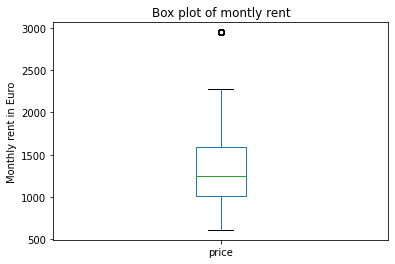

In [1125]:
apt_data['price'].plot(kind='box')
plt.title('Box plot of montly rent')
plt.ylabel('Monthly rent in Euro')
plt.show

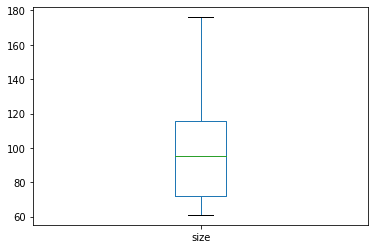

In [1126]:
apt_data['size'].plot(kind='box')

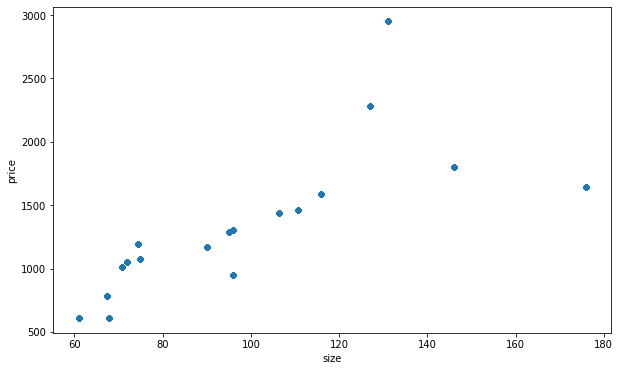

In [1127]:
apt_data.plot(kind='scatter',x='size',y='price',figsize=(10,6))